# Heat equation - Retrieving operator through ODE solving

In [1]:
# Import packages
import os
import argparse
import time
import numpy as np
import pylab as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from torchdiffeq import odeint_adjoint as odeint

from graphic_tools import simple_plotter, show_state, animate_plot
from heat import get_heat, get_heat_grad_t, get_heat_fd, get_heat_fe

## Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

<IPython.core.display.Javascript object>


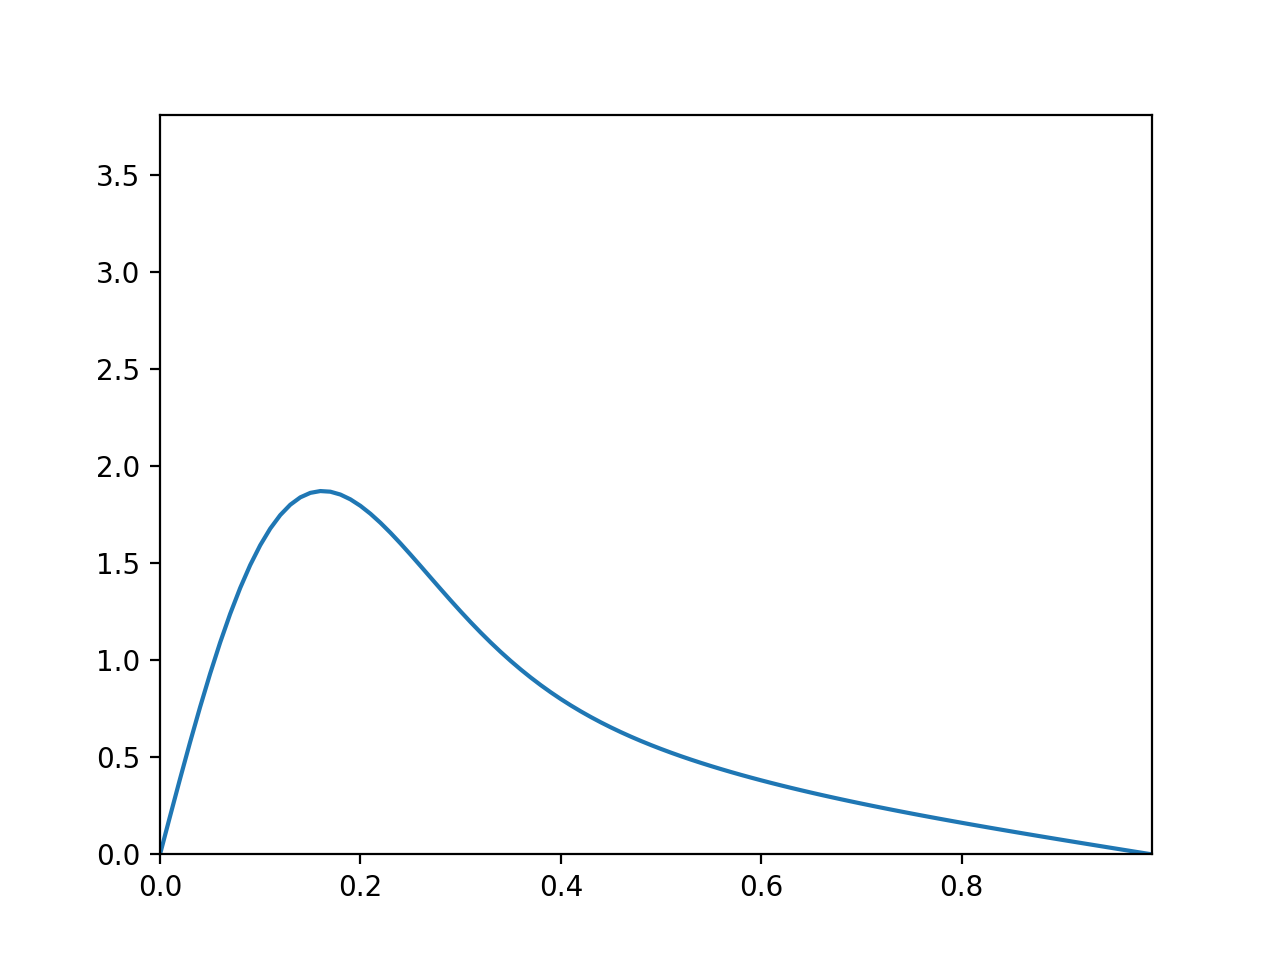

In [11]:
%matplotlib notebook

u_true, cn = get_heat(0.2, 0., 1., 0., 100, 100, False)
g_u_true = get_heat_grad_t(0.2, 0., 1., 0., 20, 50, cn)

x = np.arange(0.0, 1.0, 0.01)
outer_ani = animate_plot(u_true[1:], x)

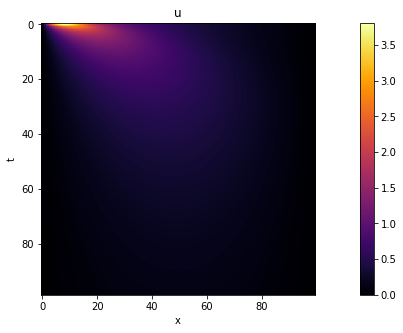

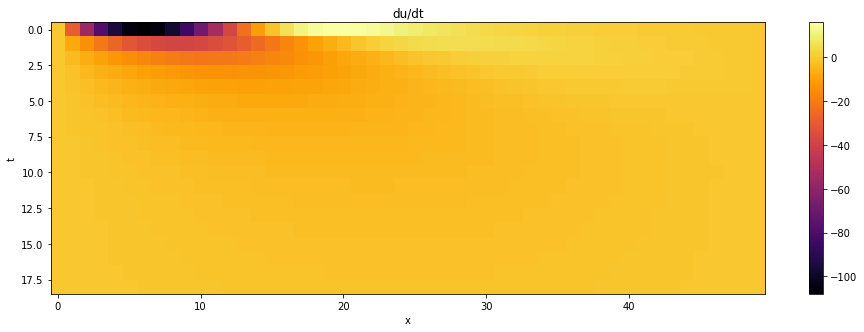

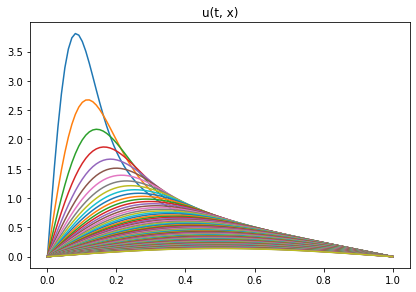

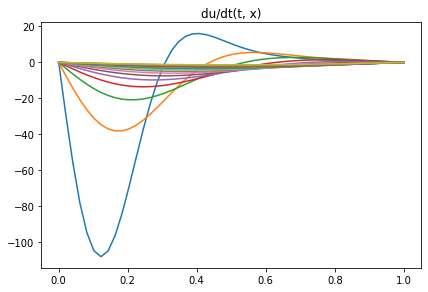

In [12]:
%matplotlib inline
show_state(u_true[1:], 'u')
show_state(g_u_true[1:], 'du/dt')

simple_plotter(u_true[1:], 'u(t, x)')
simple_plotter(g_u_true[1:], 'du/dt(t, x)')

### Different methods

We make usage of different method to evaluate a solution to the heat equation. Starting from the well-known analytical solution to the equation $u(x,t) = \sum^{\inf}_{n=1} c_n e^{-\pi^2 n^2 t} sin(n \pi x)$,
we implemented as well a finite-difference and finite-element solution.

While for testing the quality of our implementation we started with the analytical solution, in the case of heat equation it is interesting to continue with the finite-difference, which (as seen below) provides more interesting results than the finite-element version. The latest one might be of better interest on a 2D heat or non-linear equation such as Burgers.

In [ ]:
u, _ = get_heat(0.001, 0., 1., 0., 20, 50)
u_fd, _ = get_heat_fd(0.001, 0., 1., 0., 20, 50)
u_fe, _ = get_heat_fe(0.001, 0., 1., 0., 20, 50)

# Keep initial conditions. Change if start from t=1
show_state(u[:], 'u')
show_state(u_fd[:], 'u_fd')
show_state(u_fe[:], 'u_fe')

---

## Get operator F

### Definition of Model used by ODE solver

In [16]:
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 50),
            nn.Sigmoid(),
            nn.Linear(50, 2)
        )
        
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, u):
        return self.net(u)

### Implementation of the neural ODE

Let's now write our neural ODE. In a first time we will generate some data and
process them in a format usable by PyTorch and the ODESolver (torchdiffeq).

In [17]:
def get_batch(t_max, t_min, x_max, x_min, t_n, x_n, x_batch_size, rand=True):
    # We generate our time and space axis
    t_range = np.linspace(t_min, t_max, t_n)[1:]
    x_range = np.linspace(x_min, x_max, x_n)
    
    # Then compute a snapshot of the solution u(t, x).
    u, _ = get_heat(t_max, t_min, x_max, x_min, t_n, x_n, rand)
    u_t = torch.from_numpy(u[1:,:]).float() # Convert to Tensor
    
    # Select random indexes for our training batch
    rand_idx = np.random.choice(np.arange(x_n, dtype=np.int64), x_batch_size, replace=False)
    rand_idx = np.sort(rand_idx)
    
    # Get the values from the x-axis and the solution u(0, x)
    batch_x0 = torch.from_numpy(x_range[rand_idx]).float()[:, np.newaxis]
    batch_u0 = u_t[0, rand_idx, np.newaxis]  # Get u(0, x)
    
    # Concatenate x and u0 values = dimension (x_batch_size, 2)
    batch_xu0 = torch.cat((batch_x0, batch_u0), 1)

    # Get the set of time values from the t-axis used by ODE solver.  dimension (t_max)
    batch_t = torch.from_numpy(t_range).float()
    
    # Get the values of u for each instant t of the batch_t
    batch_u = torch.stack([u_t[i, rand_idx] for i in range(0, t_n - 1)], dim=0)[:, :, np.newaxis] # dim (t_max, x_batch_size, 1)
    batch_x = torch.from_numpy(x_range[rand_idx]).float().repeat(t_n - 1, 1)[:, :, np.newaxis] # dim (t_max, x_batch_size, 1)
    
    # Concatenate x and u values.  dimension (t_max, x_batch_size, 2)
    batch_xu = torch.cat((batch_x, batch_u), 2)
    
    return batch_t, batch_xu0, batch_xu

In [18]:
# t, b0, by = get_batch(0.2, 1., 10, 10, 5, False)
# print(t.size())
# print(b0.size())
# print(by.size())

Let's write a small training loop for our neural ode.

In [31]:
def training_ode_solver_net(net, epochs=100, t_n=20, x_n=100, batch_size=10, val_epoch=10):
    loss_fn = nn.MSELoss()
    optimizer = optim.RMSprop(net.parameters(), lr=0.003)

    for e in range(1, epochs + 1):
        loss_tot = 0
        
        net.train()
        for i in range(int(x_n / batch_size)):
            optimizer.zero_grad()
            
            t, b0, bu = get_batch(0.2, 0.0, 1., 0.0, t_n, x_n, batch_size)
            pred_u = odeint(net, b0, t)  # net = F
            #loss = torch.mean(torch.square(pred_u[:,:,0] - bu[:,:,0])) + torch.mean(torch.square(pred_u[:,:,1] - bu[:,:,1])) # loss_fn(pred_u, u_true)
            
            loss1 = loss_fn(pred_u[:,:,0], bu[:,:,0]) 
            loss2 = loss_fn(pred_u[:,:,1], bu[:,:,1])
            loss = loss1 + loss2
            loss_tot += loss.item()
            loss.backward(retain_graph=True)
            
            optimizer.step()
    
        val_loss_tot = 0
        if (e >= val_epoch):
            net.eval()
            for i in range(int(x_n / batch_size)):
                t_val, b0_val, bu_val = get_batch(0.4, 0.2, 1., 0.0, t_n, x_n, batch_size)
                pred_val = odeint(net, b0_val, t_val)
                val_loss1 = loss_fn(pred_val[:,:,0], bu_val[:,:,0]) 
                val_loss2 = loss_fn(pred_val[:,:,1], bu_val[:,:,1])
                val_loss = val_loss1 + val_loss2
                val_loss_tot += val_loss.item()
        
        if e % 10 == 0:
            t, b0, bu = get_batch(1., 0.0, 1., 0.0, t_n, x_n, x_n)
            visualize_u_from_F(net, t, b0)
            print('epoch %d f loss %f'%(e, float(loss_tot / float(x_n / batch_size))))
            print('epoch %d validation loss %f'%(e, float(val_loss_tot / float(x_n / batch_size))))
            
    return net

## Visualization

In [32]:
def visualize_u_from_F(F, t, u0): # t_n, x_n, t_max, x_max, t_idx=0:
    plt.figure(dpi=150)
    pred_u = odeint(F, u0, t).detach().numpy()
    color = ['b','r','g','y']
    i = t.shape[0] - 1
    
    #plt.plot(pred_u[:, :, 0], pred_u[:, :, 1], 'b--')
        
    for j in range(int(len(pred_u[i]))):
        zx = pred_u[i,j,0]
        zu = pred_u[i,j,1]
        plt.scatter(zx, zu, s=5, c='b')

epoch 10 f loss 0.152080
epoch 10 validation loss 0.028667
epoch 20 f loss 0.062352
epoch 20 validation loss 0.026997
epoch 30 f loss 0.064370
epoch 30 validation loss 0.023037
epoch 40 f loss 0.096695
epoch 40 validation loss 0.034588
epoch 50 f loss 0.059805
epoch 50 validation loss 0.032373
epoch 60 f loss 0.057410
epoch 60 validation loss 0.027782


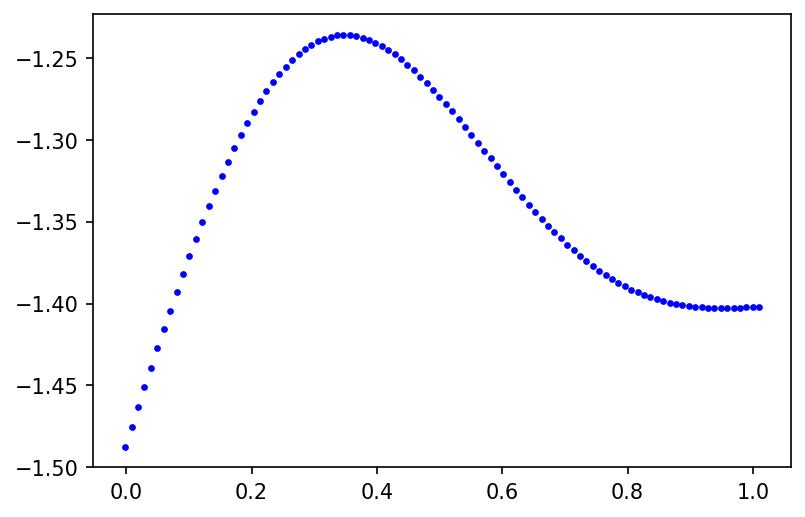

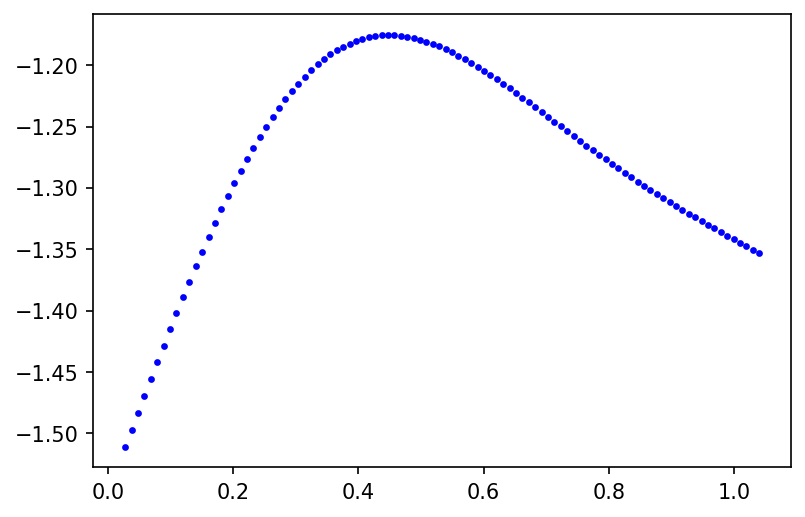

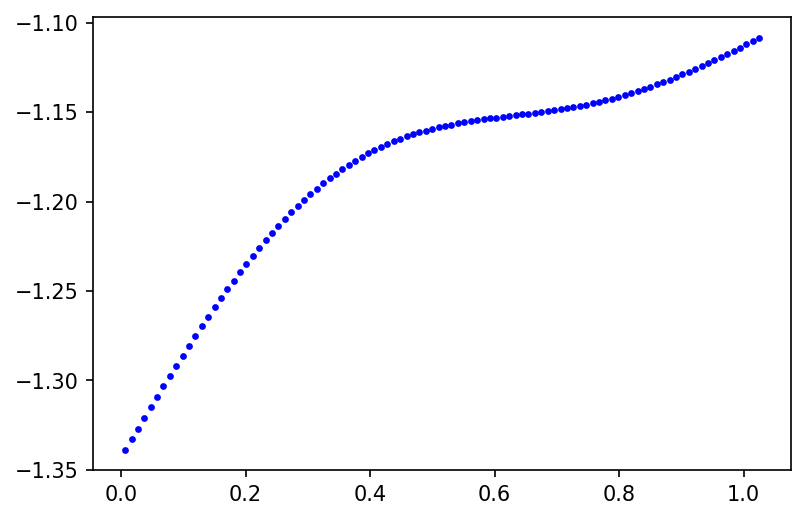

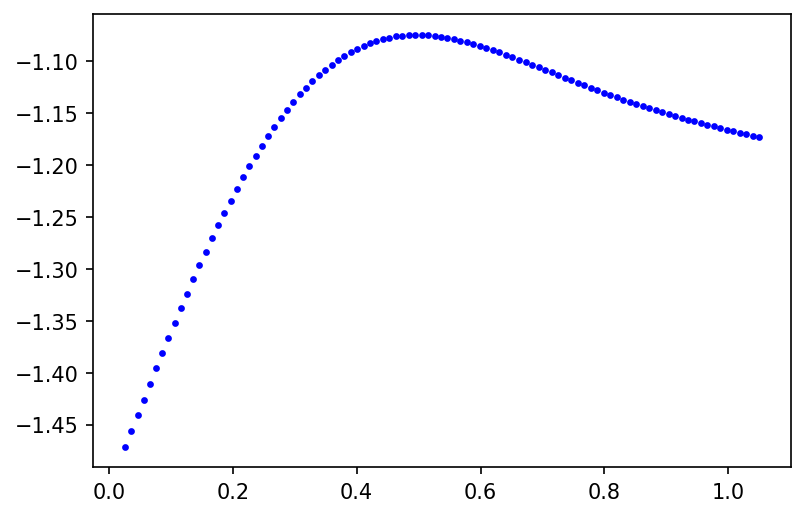

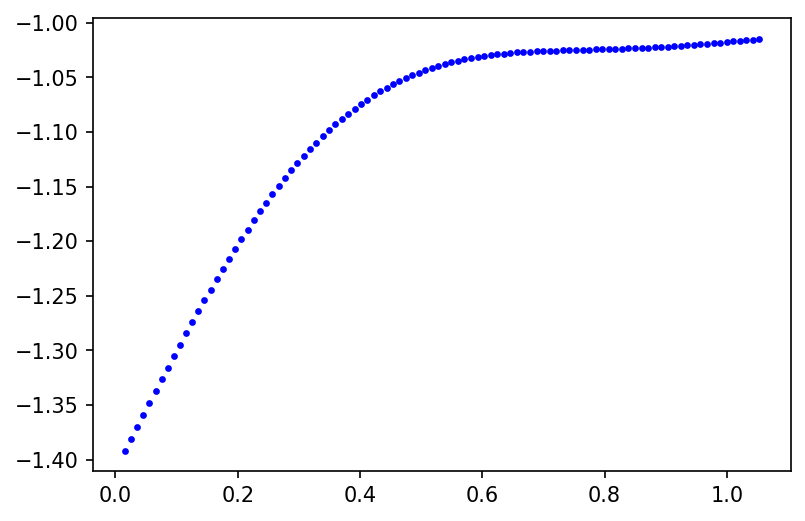

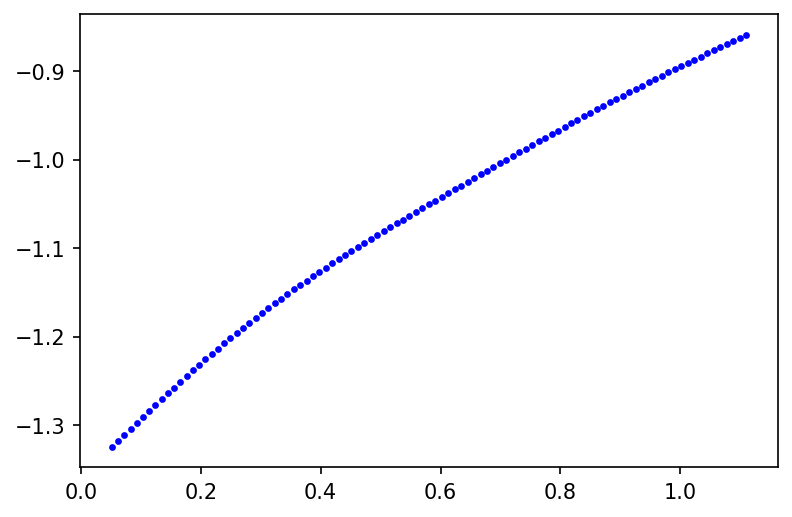

In [33]:
net = ODEModel()
F = training_ode_solver_net(net, 60, 20, 100, 50, 10)

In [34]:
def visualize_F_with_u(F, t_n=20, x_n=100):
    u, x = np.mgrid[-0.2:0.2:10j, 0.:1.:10j]
    grid_xu = torch.from_numpy(np.stack([x, u], -1).reshape(x_n * x_n, 2)).float()
    t = torch.Tensor(np.linspace(0., 1.0, t_n))
    u_m = np.zeros((t_n, x_n * x_n, 2))

    for i in range(1, t_n):
        tmp = F(0, grid_xu).detach().numpy()
        u_m[i] = tmp
    
    color = ['b','r','g','y']
    width=200
    height=150
    
    for i in [5]: # range(1, t_n, 5):
        xlims = (u_m[i, :, 0].min(), u_m[i, :, 0].max())
        ylims = (u_m[i, :, 1].min(), u_m[i, :, 1].max())
        dx = xlims[1] - xlims[0]
        dy = ylims[1] - ylims[0]
        
        buffer = np.zeros((height+1, width+1))
        
        for j, p in enumerate(u_m[i, :, :]):
            x0 = int(round(((p[0] - xlims[0]) / dx) * width))
            y0 = int(round((1 - (p[1] - ylims[0]) / dy) * height))
            buffer[y0, x0] += 0.3
            if buffer[y0, x0] > 1.0: buffer[y0, x0] = 1.0
        
        ax_extent = list(xlims)+list(ylims)
        plt.figure(dpi=150)
        plt.imshow(
            buffer,
            vmin=0,
            vmax=1, 
            cmap=plt.get_cmap('hot'),
            interpolation='lanczos',
            aspect='auto',
            extent=ax_extent)
            
    return u_m

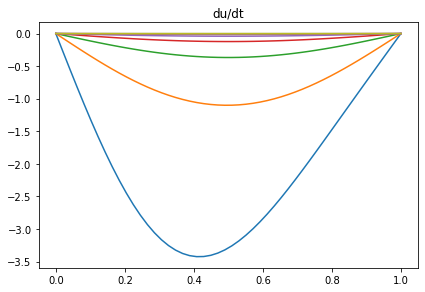

In [35]:
# W compute u(t,x) to use the same set of constants c for du/dt.
u, cn = get_heat(1., 0., 1., 0., 20, 50, True)
g_u = get_heat_grad_t(1.0, 0.0, 1.0, 0.0, 10, 50, cn)[1:]
simple_plotter(g_u, 'du/dt')
# test = visualize_F_with_u(F, 20, 10)

What is happening here ?
We display du/dt for a set of grid points (t, x) to have an overall idea of the derivative shape.
With the operator F, we provide a different set of values, has we generate grid points (x, u).
While the results will be different, it clearly apppears we do not get the same shapes.


In [ ]:
u_true, cn = get_heat(1., 0., 1., 0., 20, 50, False)
simple_plotter(u_true[1:3], 'u(t, x)')

t, u0, _ = get_batch(1., 1., 20, 100, 100)          
visualize_u_from_F(F, t[1:3], u0) #  20, 100, 1., 1., 19

---

## Analysis

We know have a working mock model. It is time to experiment reconstruction through different variants of our problem: 
- Introduce different initial conditions
- Introduce different boundary conditions (Dirichlet, Neumann, Robin)
- Introduce noise
- Switch to a reduce order model (ROM) such as the simple POD.
- Investigate the choice of the NN model.

It would be interesting to evaluates these questions:
- How stable is the inversion considering the noise in temperature and measurement of the flux?
- Which conditions are required to uniquely determine the original data?

#### FOM

Coarse-grid resolution: 
- $t_{max} = 0.2$
- $x_{max} = 1.0$
- $t_n = 100$
- $x_n = 100$

#### Initial conditions

Let's consider these set of initials conditions:
- $u(0, x) = 0$
- $u(0, x) = \sum_n^{\inf} c_n e^{-\frac{\pi^2 n^2 t}{L}} sin(\pi n x)$

#### Boundary conditions

- Dirichlet: $u(t, a) = u(t, b) = 0, a <= x <= b$
- Neumann: $u_x(t, a) = u_x(t, b) = 0, a <= x <= b$